In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import glob
import requests

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

In [2]:
df_styles = pd.read_csv("../../styles.csv", error_bad_lines=False)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
df_styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


[Text(0, 0, 'Tshirts'),
 Text(0, 0, 'Shirts'),
 Text(0, 0, 'Casual Shoes'),
 Text(0, 0, 'Watches'),
 Text(0, 0, 'Sports Shoes')]

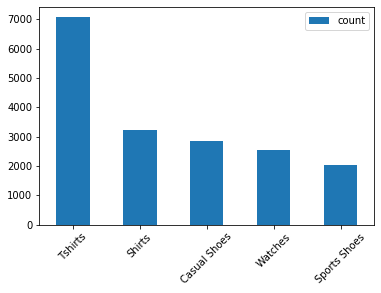

In [4]:
n_top = 5
df_top_5 = df_styles.groupby(['subCategory', 'articleType'])['id'].agg({'count'}).sort_values(by = 'count', ascending = False).nlargest(n_top, 'count').reset_index()

df_top_5.plot(kind = 'bar').set_xticklabels(df_top_5.articleType, rotation = 45)

In [5]:
df_top_categories = df_styles[
    df_styles['articleType'].isin(list(df_top_5['articleType']))
]

In [6]:
df_top_categories.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt


In [7]:
minimum_values = 500
df_stratified_sample = df_top_categories.groupby('articleType', group_keys=False).apply(lambda x: x.sample(min(len(x), minimum_values)))

In [8]:
df_stratified_sample = shuffle(df_stratified_sample).reset_index(drop = True)
df_stratified_sample.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,19764,Women,Accessories,Watches,Watches,Pink,Winter,2016.0,Casual,Ice Women Love Pink d ial Watch
1,58819,Women,Footwear,Shoes,Casual Shoes,Grey,Fall,2012.0,Casual,Skechers Women Grey Casual Shoes
2,40448,Men,Footwear,Shoes,Casual Shoes,Brown,Winter,2018.0,Casual,Red Tape Men Brown Shoes
3,35671,Men,Footwear,Shoes,Casual Shoes,Blue,Spring,2013.0,Casual,U.S. Polo Assn. Men Blue Boat Shoes
4,34031,Boys,Apparel,Topwear,Shirts,Blue,Summer,2012.0,Casual,Gini and Jony Boys Check Blue Shirt


In [9]:
# df_stratified_sample.to_pickle("../df_stratified_sample.csv")
df_stratified_sample = pd.read_pickle('../df_stratified_sample.csv')

#### Reading Data

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import IPython.display as display

In [11]:
input_shape = (240, 180, 3)

In [42]:
local_file_path = "../../images/{}.jpg"
img_data, to_fetch = [], []
df_images = pd.read_csv("../../images.csv") # incase any file is missing

for image_id in df_stratified_sample.id:
    file_path = local_file_path.format(str(image_id))
    
    temp = load_img(
        path = file_path, 
        color_mode = 'rgb', 
        target_size = input_shape,
        interpolation = 'nearest'
    )

    img_data.append(img_to_array(temp, data_format = 'channels_last'))

In [43]:
img_data = np.array(img_data)
img_data_normal = img_data/255

## Making labels

In [46]:
df_stratified_sample['articleType'] = df_stratified_sample['articleType'].astype('category')
df_stratified_sample['label'] = df_stratified_sample['articleType'].cat.codes

In [50]:
df_stratified_sample_reduce = df_stratified_sample.filter(['id', 'label'])
labels = df_stratified_sample_reduce.label.values

df_stratified_sample_reduce.head()

,id,label
0,1928,3
1,4694,4
2,38023,4
3,38648,0
4,39642,0


## Dataset split

In [86]:
from sklearn.model_selection import train_test_split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    img_data_normal, 
    labels,
    test_size = 0.3,
    random_state = 1769
)

In [95]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1750, 240, 180, 3), (750, 240, 180, 3), (1750,), (750,))

## Model

In [99]:
from tensorflow.keras import models, layers

In [112]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(240, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [113]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 238, 178, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 119, 89, 32)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 117, 87, 64)       18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 58, 43, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 56, 41, 64)        36928     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 54, 39, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 27, 19, 128)      

In [114]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics = ['accuracy'])

In [115]:
model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    validation_data = (X_test, y_test)
)

Train on 1750 samples, validate on 750 samples
Epoch 1/10
1750/1750 [==============================] - 78s 45ms/sample - loss: 7.6356 - accuracy: 0.1914 - val_loss: 6.8410 - val_accuracy: 0.2200
Epoch 2/10
1750/1750 [==============================] - 83s 47ms/sample - loss: 7.6958 - accuracy: 0.1914 - val_loss: 6.8151 - val_accuracy: 0.2200
Epoch 3/10
1750/1750 [==============================] - 84s 48ms/sample - loss: 7.7399 - accuracy: 0.1914 - val_loss: 6.9156 - val_accuracy: 0.2213
Epoch 4/10
1750/1750 [==============================] - 82s 47ms/sample - loss: 5.2207 - accuracy: 0.2469 - val_loss: 4.2094 - val_accuracy: 0.3707
Epoch 5/10
1750/1750 [==============================] - 81s 46ms/sample - loss: 5.9455 - accuracy: 0.2469 - val_loss: 7.0301 - val_accuracy: 0.1867
Epoch 6/10
1750/1750 [==============================] - 82s 47ms/sample - loss: 7.7669 - accuracy: 0.2057 - val_loss: 7.0301 - val_accuracy: 0.1867
Epoch 7/10
1750/1750 [==============================] - 82s 47ms/